In [1]:
#necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
import keras
from keras import layers
from keras import ops
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import datetime
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import PIL.Image
import matplotlib 
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import shutil
import posixpath
import sys 
import glob
#import wfdb
import pandas as pd
import math
from PIL import Image

In [2]:
#import keras
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
from keras.models import Sequential
from sklearn.metrics import accuracy_score, f1_score

In [11]:
#pip install tensorflow

In [3]:
tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 10})

device_count {
  key: "CPU"
  value: 10
}
device_count {
  key: "GPU"
  value: 1
}

In [ ]:
#%reset -f

In [5]:
#class_present = ['Bundle branch block','Cardiomyopathy','Dysrhythmia','Healthy control','Heart failure (NYHA 2)',
# 'Heart failure (NYHA 3)','Heart failure (NYHA 4)','Hypertrophy', 'Myocardial Infarction'
#'Myocarditis','Palpitation', 'Stable angina', 'Unqualified', 'Unstable angina', 'Valvular heart disease']
class_present = ['Healthy control', 'Myocardial Infarction']

In [5]:
img = 'E:/Jupyter/A_DNN/ptb_resnet_rerun/second_arch/ii/Healthy control/948.csv.png'
image = Image.open(img)

In [6]:
image.size  ##old size = 640,480

(224, 224)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [10]:
##clear session to clear memory for next model
tf.keras.backend.clear_session()

In [11]:
##train resnet50 on ii(rhythm strip) v6(anterior segment) vz(part of vectorcardiogram)
train_dataset_ii = tf.keras.preprocessing.image_dataset_from_directory(
    './ptb_resnet_rerun/second_arch/ii/',
    image_size=(224, 224),
    batch_size=16,
    validation_split=0.2,
    subset='training',
    shuffle=True,
    seed=39  ##no weights initialized here by deafult so not used
)

Found 1280 files belonging to 2 classes.
Using 1024 files for training.


In [12]:
val_dataset_ii = tf.keras.preprocessing.image_dataset_from_directory(
    './ptb_resnet_rerun/second_arch/ii/',
    image_size=(224, 224),
    batch_size=16,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    seed=39  ##no weights initialized here by deafult so not used
)

Found 1280 files belonging to 2 classes.
Using 256 files for validation.


In [13]:
##set objective function that controls the number of layers
##TARGET: USE PSO WHERE EACH PARTICLE USES ITS PARAMETERS TO FIND THE BEST NUMBER OF LAYERS 
##SUCH THAT THE MODEL YIELDS THE BEST ACCURACY OR F1 SCORE
##IN NON-OPT MODELS, THE MAIN ISSUE WAS THE RECALL AND ROC 
def objective_function(num_layers): ##take the num of layers: optimize the DL architecture
    model_ii = keras.Sequential() 
    ##TARGET: get the operation of each particle and use it on swarm velocity and position calculationc
    ##default model weights
    custom_model_ii = ResNet50(include_top=False, weights='imagenet', input_tensor=None, 
                 input_shape=(224, 224, 3), classes=2, classifier_activation="softmax")
    for layer in custom_model_ii.layers:
        layer.trainable=False

    model_ii.add(keras.Input(shape=(224,224,3)))
    model_ii.add(custom_model_ii)
    model_ii.add(layers.Flatten())
    
    for _ in range(num_layers):
        model_ii.add(layers.Dense(1024, activation= 'relu'))
        model_ii.add(layers.Dense(512, activation= 'relu'))
    
    model_ii.add(layers.Dense(2, activation='softmax'))
    model_ii.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_ii.fit(train_dataset_ii, epochs=10)  ##change from 20 to 5 epochs to 10
   
    y_pred_prob = model_ii.predict(val_dataset_ii)
    y_val = np.concatenate([y for x, y in val_dataset_ii], axis=0)
    y_val_2 = y_val.flatten()
    y_pred_prob_2 = y_pred_prob.flatten()
    fpr, tpr, _ = roc_curve(y_val_2[:256], y_pred_prob_2[:256])
    roc_auc = auc(fpr, tpr)
    #f1 = f1_score(y_val, y_pred_prob)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    return -roc_auc  # PSO minimizes, so we negate f1_score, area under curve, accuracy

##set pso 
def pso(objective_function, n_particles, n_iterations, search_space):
    #Initialize swarm randomly per particle
    ##the search space is the number of layers that can be added
    swarm_position = np.random.randint(search_space[0], search_space[1] + 1, size=n_particles)
    swarm_velocity = np.random.uniform(-1, 1, size=n_particles)
    swarm_best_position = swarm_position.copy()
    swarm_best_score = np.zeros(n_particles)

    global_best_position = 0
    global_best_score = float('inf')

    # PSO optimization loop
    for _ in range(n_iterations):
        for j in range(n_particles):
            # Evaluate objective function
            score = objective_function(swarm_position[j])   ##score of training that particle
            # Update swarm best
            if score < swarm_best_score[j]:
                swarm_best_position[j] = swarm_position[j]
                swarm_best_score[j] = score
            # Update global best
            if score < global_best_score:
                global_best_position = swarm_position[j]
                global_best_score = score
        # Update velocities and positions
        inertia_weight = 0.7  # inertia weight
        cognitive_weight = 1.5  # cognitive component weight
        social_weight = 1.5  # social component weight
        r1 = np.random.rand()
        r2 = np.random.rand()
        swarm_velocity = (inertia_weight * swarm_velocity +
                          cognitive_weight * r1 * (swarm_best_position - swarm_position) +
                          social_weight * r2 * (global_best_position - swarm_position))
        swarm_position = np.clip(np.round(swarm_position + swarm_velocity), search_space[0], search_space[1])

    return int(global_best_position)

Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 1504s 23s/step - accuracy: 0.7260 - loss: 2.2885
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 1069s 16s/step - accuracy: 0.9135 - loss: 0.2084
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 645s 10s/step - accuracy: 0.9527 - loss: 0.1874
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step


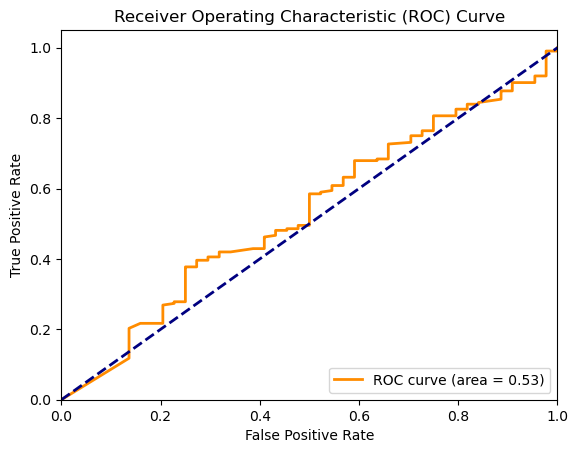

Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 896s 13s/step - accuracy: 0.7704 - loss: 10.4685
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 1085s 17s/step - accuracy: 0.9181 - loss: 0.4183
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 1176s 18s/step - accuracy: 0.9760 - loss: 0.0702
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step


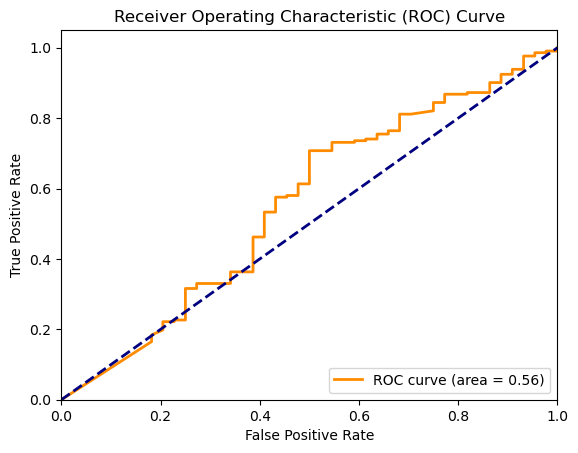

Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 983s 14s/step - accuracy: 0.7527 - loss: 0.5072
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 813s 12s/step - accuracy: 0.8196 - loss: 0.3579
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 1318s 20s/step - accuracy: 0.9344 - loss: 0.2171
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


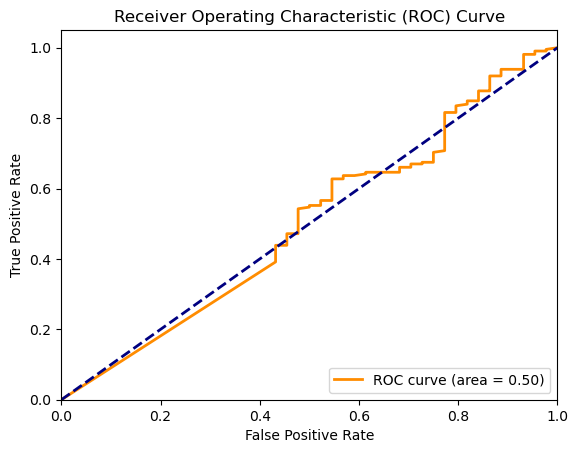

In [14]:
search_space = (1, 10)  ##expected number of layers
best_num_layers = pso(objective_function, n_particles=3, n_iterations=1, search_space=search_space)

In [15]:
print("Best number of layers found by PSO:", best_num_layers)

Best number of layers found by PSO: 1


### _DELETED_:Input Parameters in PSO trials, yield random results 

In [10]:
model_ii = keras.Sequential()

In [1]:
#!pip install --upgrade keras

In [11]:
##default model weights
custom_model_ii = ResNet50(include_top=False, weights='imagenet', input_tensor=None, 
                 input_shape=(224, 224, 3), classes=2, classifier_activation="softmax")

for layer in custom_model_ii.layers:
    layer.trainable=False

model_ii.add(keras.Input(shape=(224,224,3)))
model_ii.add(custom_model_ii)
model_ii.add(layers.Flatten())
#model_ii.add(Dense(512, activation='relu'))
model_ii.add(layers.Dense(1024, activation= 'relu'))  ##4096
#model_ii.add(Dense(4096, activation= 'relu'))
model_ii.add(layers.Dense(512, activation= 'relu'))   ##1000
model_ii.add(layers.Dense(2, activation='softmax'))  ##no of classes

In [32]:
#custom_model_ii.layers

In [10]:
##include confusion matrix, fail to rerun with top so manually decode predictions

In [32]:
model_ii.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │     102,761,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,875,010 (483.99 MB)

 Trainable params: 103,287,298 (394.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
def set_model_weights(params):
    for i in range(len(model_ii_params_tensors)):
        model_ii_params[i] = params[i]
    model_ii.set_weights(model_ii_params_tensors)

def objective_function(params):
    set_model_weights(params)
    model_ii.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_ii.fit(train_dataset_ii, epochs=20)
    _, accuracy = model_ii.evaluate(val_dataset_ii)#, verbose=0)
    return -accuracy  # PSO minimizes the objective function, so we negate the accuracy


def pso(objective_function, n_particles, n_iterations):
    # Initialize swarm
    swarm_position = np.random.uniform(-1, 1, size=(n_particles, len(model_ii_params)))
    swarm_velocity = np.random.uniform(-0.1, 0.1, size=(n_particles, len(model_ii_params)))
    swarm_best_position = swarm_position.copy()
    swarm_best_score = np.zeros(n_particles)

    global_best_position = np.zeros(len(model_ii_params))
    global_best_score = float('inf')

    # PSO optimization loop
    for i in range(n_iterations):
        for j in range(n_particles):
            # Evaluate objective function
            score = objective_function(swarm_position[j])
            # Update swarm best
            if score < swarm_best_score[j]:
                swarm_best_position[j] = swarm_position[j].copy()
                swarm_best_score[j] = score
            # Update global best
            if score < global_best_score:
                global_best_position = swarm_position[j].copy()
                global_best_score = score
        # Update velocities and positions
        inertia_weight = 0.7  # inertia weight
        cognitive_weight = 1.5  # cognitive component weight
        social_weight = 1.5  # social component weight
        r1 = np.random.rand(len(model_ii_params))
        r2 = np.random.rand(len(model_ii_params))
        swarm_velocity = (inertia_weight * swarm_velocity +
                          cognitive_weight * r1 * (swarm_best_position - swarm_position) +
                          social_weight * r2 * (global_best_position - swarm_position))
        swarm_position += swarm_velocity

    return global_best_position

In [ ]:
model_ii_params = model_ii.get_weights()
model_ii_params_tensors = [tf.convert_to_tensor(param) for param in model_ii_params]

In [ ]:
#model_ii_params = model_ii.get_weights()

best_params = pso(objective_function, n_particles=10, n_iterations=20)
set_model_weights(best_params)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 858s 13s/step - accuracy: 0.7561 - loss: 10.2052
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 992s 15s/step - accuracy: 0.9296 - loss: 0.7603
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 726s 11s/step - accuracy: 0.9225 - loss: 0.6603
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 562s 9s/step - accuracy: 0.9824 - loss: 0.0971
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 441s 7s/step - accuracy: 0.9927 - loss: 0.0245
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - accuracy: 1.0000 - loss: 9.2430e-05
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 1.0000 - loss: 1.0965e-05
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 1.0000 - loss: 7.7347e-06
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 229s 3s/step - accuracy: 1.0000 - loss: 5.4625e-06
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2558s 40s/step - accuracy: 1.0000 - loss: 4.5220e-06
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 486s 7s/step - accuracy: 1.0000 - loss: 4.0512e-06
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━

In [30]:
#model_ii.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
best_params.save('./models/resnet50_ii_pso.keras')
#model_ii.save('./models/resnet50_ii_pso.keras')

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [20]:
##plot graphs
y_pred_prob = model_ii.predict(val_dataset_ii)

16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step


In [21]:
y_val = np.concatenate([y for x, y in val_dataset_ii], axis=0)

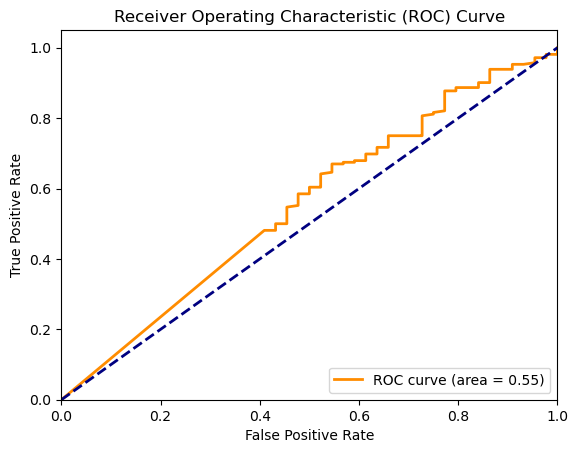

In [23]:
y_val_2 = y_val.flatten()
y_pred_prob_2 = y_pred_prob.flatten()
fpr, tpr, _ = roc_curve(y_val_2[:256], y_pred_prob_2[:256])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [25]:
y_true = np.concatenate([y for _, y in val_dataset_ii], axis=0)

In [64]:
#y_true

In [26]:
flat_preds = y_pred_prob.flatten()
y_pred_prob_2 = []
for i in range(0,len(flat_preds)):
    y_pred_prob_2.append(int(flat_preds[i]))

In [27]:
y_pred_prob_new = np.array(y_pred_prob_2)
#y_pred_prob_new

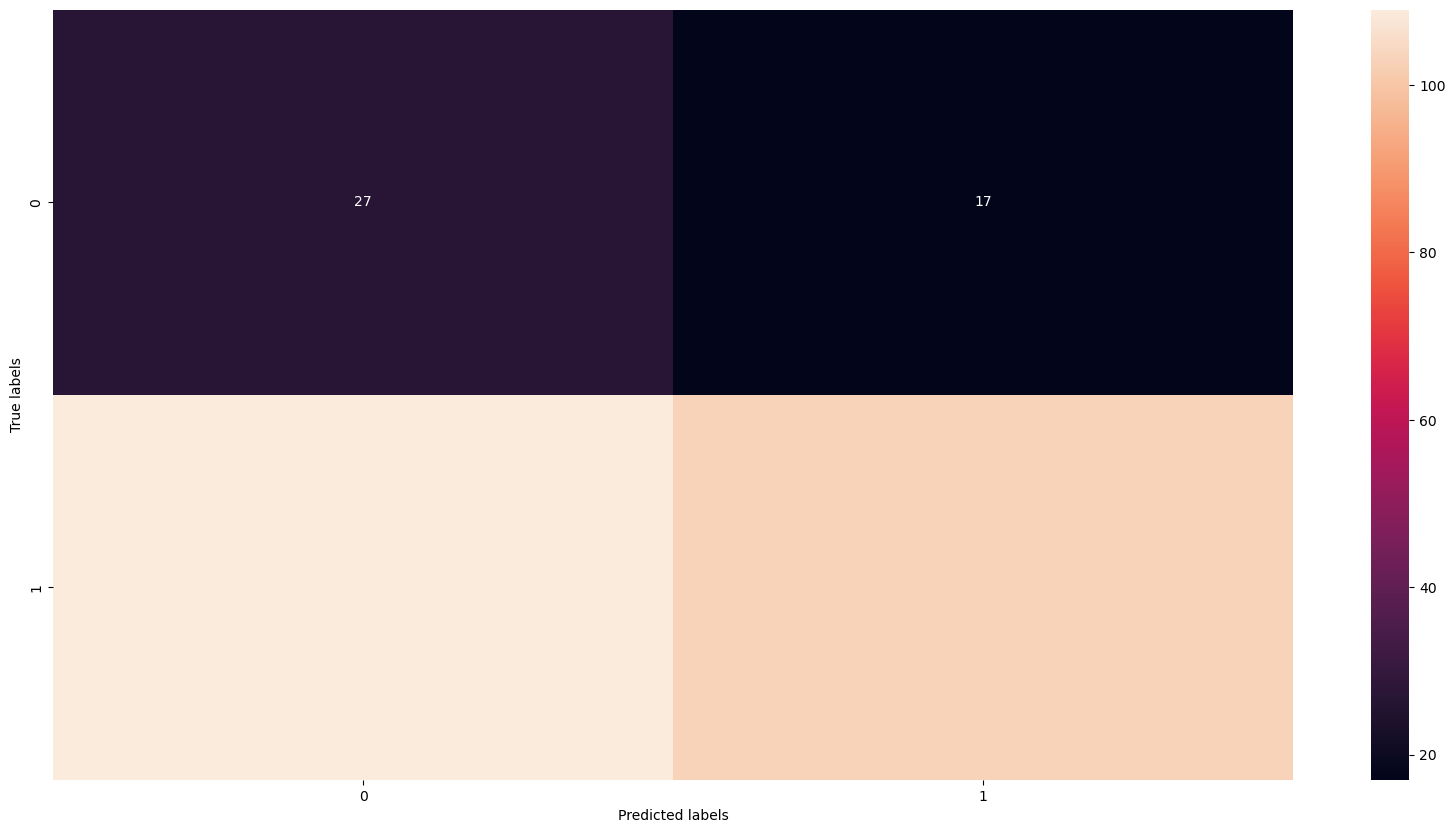

In [28]:
cm = confusion_matrix(y_true[:256], y_pred_prob_new[:256])
convnet_df_cm = pd.DataFrame(cm)
plt.figure(figsize = (20,10))
sns.heatmap(convnet_df_cm, annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [29]:
from sklearn.metrics import classification_report
report = classification_report(y_true[:256], y_pred_prob_new[:256])

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.61      0.30        44
           1       0.86      0.49      0.62       212

    accuracy                           0.51       256
   macro avg       0.53      0.55      0.46       256
weighted avg       0.74      0.51      0.57       256



# ____END OF II-IMAGE BASED TRAINING_

In [ ]:
##clear session to clear memory for next model
tf.keras.backend.clear_session()

In [30]:
train_dataset_v6 = tf.keras.preprocessing.image_dataset_from_directory(
    './ptb_resnet_rerun/second_arch/v6/',
    image_size=(224, 224),
    batch_size=16,
    validation_split=0.2,
    subset='training',
    shuffle=True,
    seed=39  ##no weights initialized here by deafult so not used
)

Found 1280 files belonging to 2 classes.
Using 1024 files for training.


In [31]:
val_dataset_v6 = tf.keras.preprocessing.image_dataset_from_directory(
    './ptb_resnet_rerun/second_arch/v6/',
    image_size=(224, 224),
    batch_size=16,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    seed=39  ##no weights initialized here by deafult so not used
)

Found 1280 files belonging to 2 classes.
Using 256 files for validation.


In [32]:
model_v6 = Sequential()

In [33]:
##default model weights
custom_model_v6 = ResNet50(include_top=False, weights='imagenet', input_tensor=None, 
                 input_shape=(224, 224, 3), classes=2, classifier_activation="softmax")

for layer in custom_model_v6.layers:
    layer.trainable=False

In [34]:
model_v6.add(keras.Input(shape=(224,224,3)))
model_v6.add(custom_model_v6)
model_v6.add(Flatten())
#model_v6.add(Dense(512, activation='relu'))
model_v6.add(Dense(1024, activation= 'relu'))  ##4096
#model_v6.add(Dense(4096, activation= 'relu'))
model_v6.add(Dense(512, activation= 'relu'))   ##1000
model_v6.add(Dense(2, activation='softmax'))  ##no of classes

In [35]:
model_v6.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │     102,761,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,875,010 (483.99 MB)

 Trainable params: 103,287,298 (394.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [36]:
model_v6.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
model_v6.fit(
    train_dataset_v6,
    #val_dataset,
    epochs=10  #20 #instead of 100, since takes too long over same accuracy, no oscillations
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1150s 17s/step - accuracy: 0.7758 - loss: 15.2703
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1317s 20s/step - accuracy: 0.9283 - loss: 0.5683
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 703s 11s/step - accuracy: 0.9640 - loss: 0.2067
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 466s 7s/step - accuracy: 0.9866 - loss: 0.0666
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 289s 4s/step - accuracy: 0.9926 - loss: 0.0369
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.9954 - loss: 0.0098
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 22646s 359s/step - accuracy: 0.9846 - loss: 0.0306
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1000s 15s/step - accuracy: 0.9844 - loss: 0.0938
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 863s 13s/step - accuracy: 0.9786 - loss: 0.1600
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 585s 9s/step - accuracy: 0.9917 - loss: 0.0122


In [38]:
model_v6.fit(
    val_dataset_v6,
    #val_dataset,
    epochs=10  #20 #instead of 100, since takes too long over same accuracy, no oscillations
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 260s 15s/step - accuracy: 0.9943 - loss: 0.0456
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 242s 14s/step - accuracy: 0.9993 - loss: 0.0037
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 214s 13s/step - accuracy: 0.9917 - loss: 0.0168
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 224s 13s/step - accuracy: 0.9950 - loss: 0.0117
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 233s 14s/step - accuracy: 1.0000 - loss: 1.5303e-04
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 253s 15s/step - accuracy: 1.0000 - loss: 3.0286e-04
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 211s 12s/step - accuracy: 1.0000 - loss: 3.3578e-06
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 201s 12s/step - accuracy: 1.0000 - loss: 2.0803e-06
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 217s 13s/step - accuracy: 1.0000 - loss: 2.1269e-06
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 248s 14s/step - accuracy: 1.0000 - loss: 2.1217e-06


In [39]:
model_v6.save('./models/resnet50_v6_images.keras')

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [67]:
y_pred_prob = model_v6.predict(val_dataset_v6)

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step


In [68]:
y_val = np.concatenate([y for x, y in val_dataset_v6], axis=0)

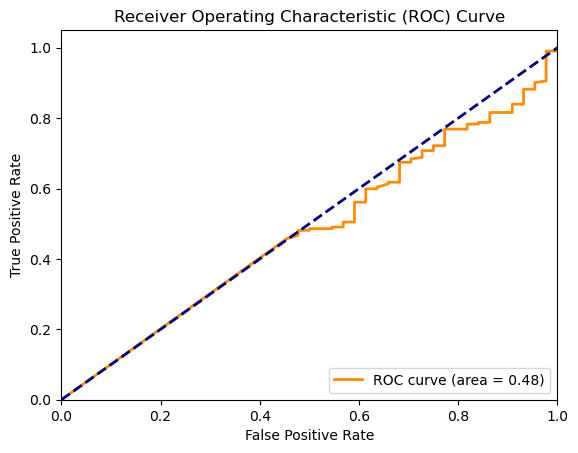

In [69]:
y_val_2 = y_val.flatten()
y_pred_prob_2 = y_pred_prob.flatten()
fpr, tpr, _ = roc_curve(y_val_2[:256], y_pred_prob_2[:256])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [44]:
y_true = np.concatenate([y for _, y in val_dataset_v6], axis=0)

In [46]:
flat_preds = y_pred_prob.flatten()
y_pred_prob_2 = []
for i in range(0,len(flat_preds)):
    y_pred_prob_2.append(int(flat_preds[i]))

In [47]:
y_pred_prob_new = np.array(y_pred_prob_2)

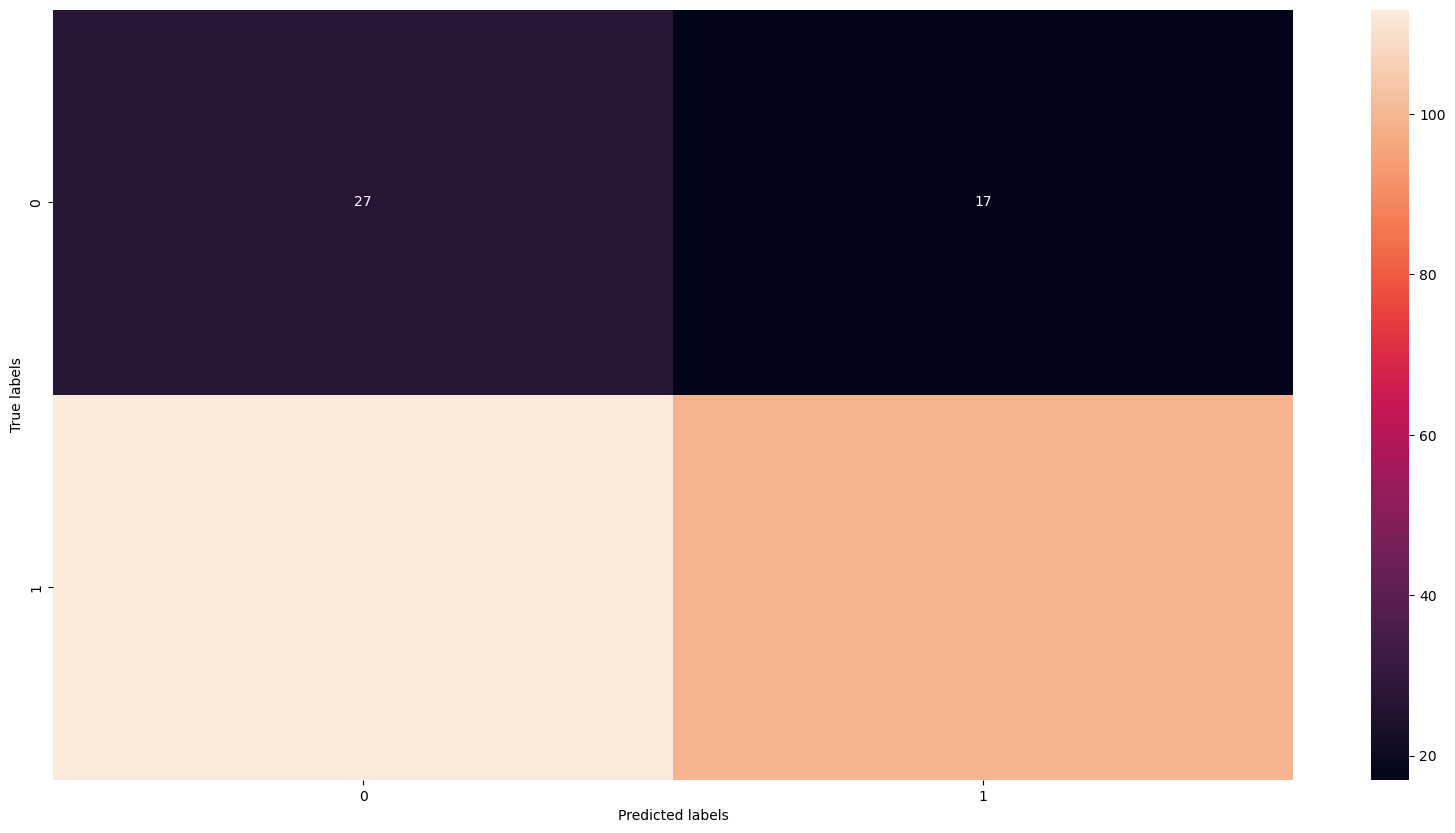

In [48]:
cm = confusion_matrix(y_true[:256], y_pred_prob_new[:256])
convnet_df_cm = pd.DataFrame(cm)
plt.figure(figsize = (20,10))
sns.heatmap(convnet_df_cm, annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [49]:
from sklearn.metrics import classification_report
report = classification_report(y_true[:256], y_pred_prob_new[:256])

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.61      0.29        44
           1       0.85      0.47      0.60       212

    accuracy                           0.49       256
   macro avg       0.52      0.54      0.45       256
weighted avg       0.74      0.49      0.55       256



# ____END OF V6-IMAGE BASED TRAINING_

In [4]:
##clear session to clear memory for next model
tf.keras.backend.clear_session()

In [5]:
train_dataset_vz = tf.keras.preprocessing.image_dataset_from_directory(
    './ptb_resnet_rerun/second_arch/vz/',
    image_size=(224, 224),
    batch_size=16,
    validation_split=0.2,
    subset='training',
    shuffle=True,
    seed=39  ##no weights initialized here by deafult so not used
)

Found 1280 files belonging to 2 classes.
Using 1024 files for training.


In [6]:
val_dataset_vz = tf.keras.preprocessing.image_dataset_from_directory(
    './ptb_resnet_rerun/second_arch/vz/',
    image_size=(224, 224),
    batch_size=16,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    seed=39  ##no weights initialized here by deafult so not used
)

Found 1280 files belonging to 2 classes.
Using 256 files for validation.


In [12]:
model_vz = Sequential()

In [13]:
##default model weights
custom_model_vz = ResNet50(include_top=False, weights='imagenet', input_tensor=None, 
                 input_shape=(224, 224, 3), classes=2, classifier_activation="softmax")

for layer in custom_model_vz.layers:
    layer.trainable=False

model_vz.add(keras.Input(shape=(224,224,3)))
model_vz.add(custom_model_vz)
model_vz.add(Flatten())
#model_vz.add(Dense(512, activation='relu'))
model_vz.add(Dense(1024, activation= 'relu'))  ##4096
#model_vz.add(Dense(4096, activation= 'relu'))
model_vz.add(Dense(512, activation= 'relu'))   ##1000
model_vz.add(Dense(2, activation='softmax'))  ##no of classes

In [14]:
model_vz.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │     102,761,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,875,010 (483.99 MB)

 Trainable params: 103,287,298 (394.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
'''pso_optimizer = ParticleSwarmOptimizer(model.parameters(),
                               inertial_weight=0.5,
                               num_particles=100,
                               max_param_value=1,
                               min_param_value=-1)'''
model_vz.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
model_vz.fit(
    train_dataset_vz,
    #val_dataset,
    epochs=10  #20 #instead of 100, since takes too long over same accuracy, no oscillations
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1146s 17s/step - accuracy: 0.7079 - loss: 19.4792
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 914s 14s/step - accuracy: 0.9231 - loss: 0.2968
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 327s 5s/step - accuracy: 0.9448 - loss: 0.1454
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - accuracy: 0.9335 - loss: 0.2808
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 416s 6s/step - accuracy: 0.9961 - loss: 0.0191
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.9952 - loss: 0.0232
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.9672 - loss: 0.1658
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.9778 - loss: 0.1096
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 15103s 239s/step - accuracy: 0.9981 - loss: 0.0251
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 441s 7s/step - accuracy: 0.9990 - loss: 0.0044


In [17]:
model_vz.fit(
    val_dataset_vz,
    #val_dataset,
    epochs=10  #20 #instead of 100, since takes too long over same accuracy, no oscillations
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 410s 25s/step - accuracy: 1.0000 - loss: 1.4048e-04
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 546s 33s/step - accuracy: 1.0000 - loss: 5.5708e-05
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 416s 24s/step - accuracy: 1.0000 - loss: 2.9146e-05
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 294s 17s/step - accuracy: 1.0000 - loss: 2.0978e-05
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 204s 12s/step - accuracy: 1.0000 - loss: 1.3672e-05
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 132s 7s/step - accuracy: 1.0000 - loss: 1.2060e-05
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 1.0000 - loss: 1.2735e-05
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 128s 7s/step - accuracy: 1.0000 - loss: 1.3341e-05
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 1.0000 - loss: 1.0859e-05
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - accuracy: 1.0000 - loss: 8.3017e-06


In [18]:
model_vz.save('./models/resnet50_vz_images.keras')

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [20]:
y_pred_prob = model_vz.predict(val_dataset_vz)

16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step


In [21]:
y_val = np.concatenate([y for x, y in val_dataset_vz], axis=0)

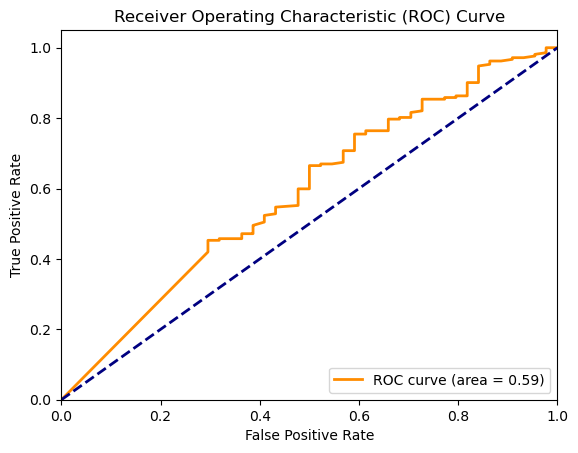

In [22]:
y_val_2 = y_val.flatten()
y_pred_prob_2 = y_pred_prob.flatten()
fpr, tpr, _ = roc_curve(y_val_2[:256], y_pred_prob_2[:256])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [24]:
y_true = np.concatenate([y for _, y in val_dataset_vz], axis=0)

In [25]:
flat_preds = y_pred_prob.flatten()
y_pred_prob_2 = []
for i in range(0,len(flat_preds)):
    y_pred_prob_2.append(int(flat_preds[i]))

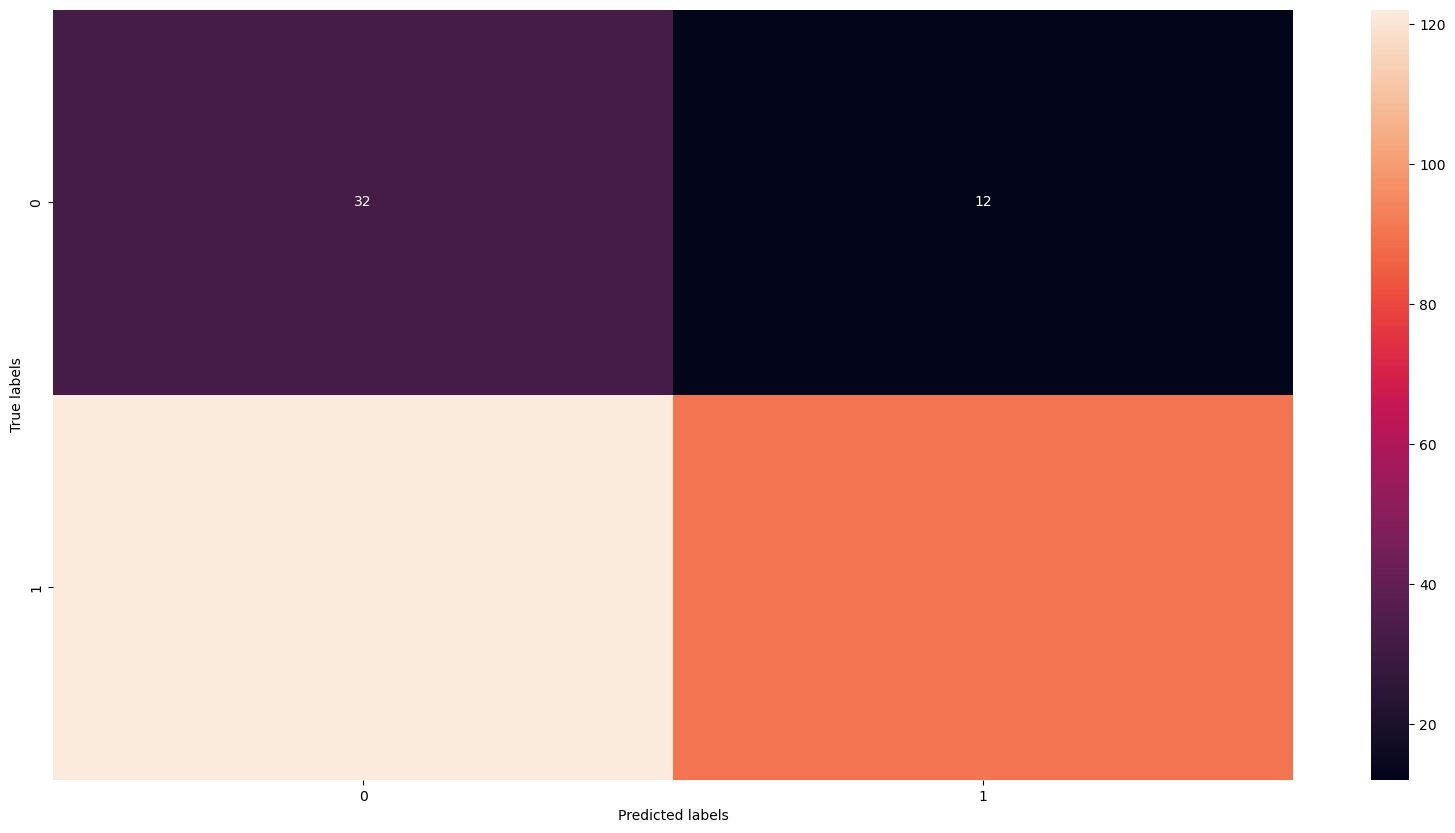

In [26]:
y_pred_prob_new = np.array(y_pred_prob_2)
cm = confusion_matrix(y_true[:256], y_pred_prob_new[:256])
convnet_df_cm = pd.DataFrame(cm)
plt.figure(figsize = (20,10))
sns.heatmap(convnet_df_cm, annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [27]:
from sklearn.metrics import classification_report
report = classification_report(y_true[:256], y_pred_prob_new[:256])

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.73      0.32        44
           1       0.88      0.42      0.57       212

    accuracy                           0.48       256
   macro avg       0.55      0.58      0.45       256
weighted avg       0.77      0.48      0.53       256



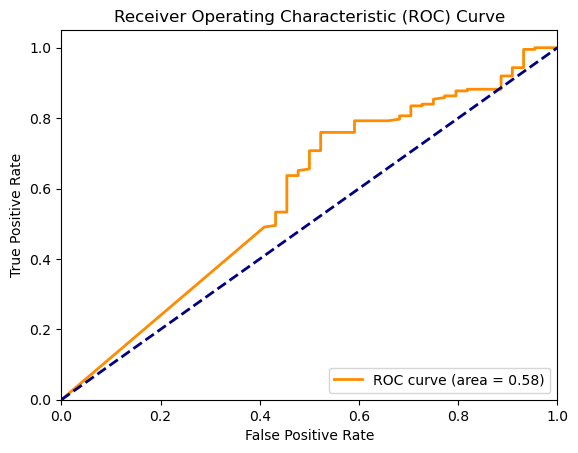

In [73]:
#####VZ CLASSIFIER ON II###SOMETIMES BETTER RESULTS
y_val_2 = y_val.flatten()
y_pred_prob_2 = y_pred_prob.flatten()
fpr, tpr, _ = roc_curve(y_val_2[:256], y_pred_prob_2[:256])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [75]:
y_true = np.concatenate([y for _, y in val_dataset_vz], axis=0)

In [76]:
flat_preds = y_pred_prob.flatten()
y_pred_prob_2 = []
for i in range(0,len(flat_preds)):
    y_pred_prob_2.append(int(flat_preds[i]))

In [77]:
y_pred_prob_new = np.array(y_pred_prob_2)

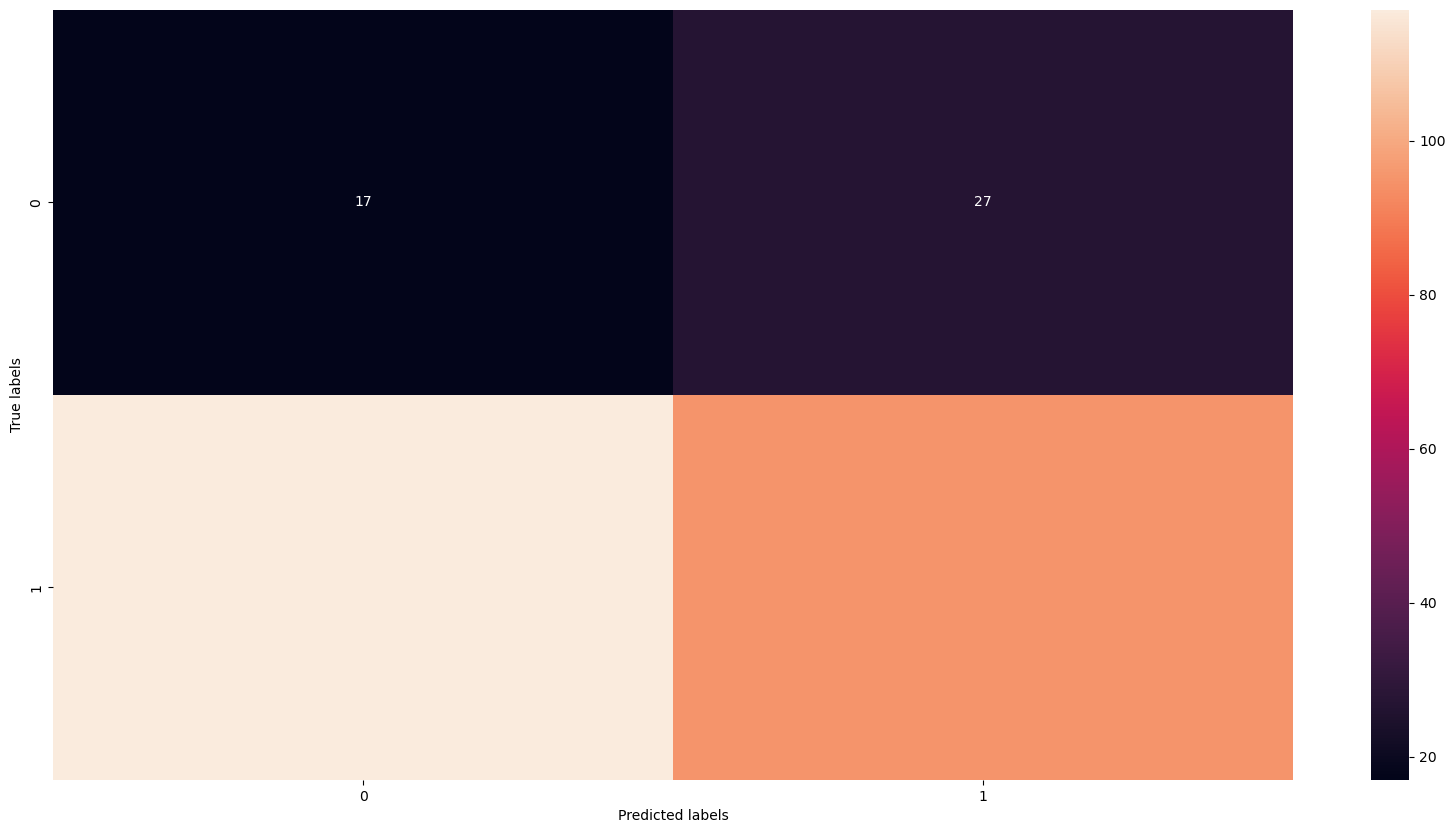

In [78]:
cm = confusion_matrix(y_true[:256], y_pred_prob_new[:256])
convnet_df_cm = pd.DataFrame(cm)
plt.figure(figsize = (20,10))
sns.heatmap(convnet_df_cm, annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [79]:
from sklearn.metrics import classification_report
report = classification_report(y_true[:256], y_pred_prob_new[:256])

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.39      0.19        44
           1       0.78      0.45      0.57       212

    accuracy                           0.44       256
   macro avg       0.45      0.42      0.38       256
weighted avg       0.67      0.44      0.50       256



# ____END OF VZ-IMAGE BASED TRAINING_

### _NOTE_: ROC curve shows performance at different classification thresholds, at model_v6, higher ROC with rhythm strip, ii. model_vz has the best ROC for all.

#### Next steps: 
#### 1) Retry with PSO, expected to have a faster model, not necessarily an increase in f1/recall score

#### 2) Generate labels from ii(rhythm strip), v6(anterior segment), vz(feature cardiograph)

#### 3) Labels are either 1 or 0. [0,0,0], [0,0,1], [1,1,0]...etc. To offset high cost of false negative(predicted is -ve MI but true is +ve MI), mark as +ve MI if any of the labels are 1. 

#### 4) Use a classification ML model to divide into 2 different categories. This is done to assess risk, error and bias of ecg diagnosis.  